In [1]:
from __future__ import annotations
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import gymnasium as gym 

class A2C(nn.Module):

    def __init__(self, n_features: int, n_actions: int, device: torch.device, critic_lr: float, actor_lr: float, n_envs: int,) -> None:
        super().__init__()
        self.device = device
        self.n_envs = n_envs

        critic_layers = [nn.Linear(n_features, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1),]
        actor_layers = [nn.Linear(n_features, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, n_actions)]

        self.critic = nn.Sequential(*critic_layers).to(self.device)
        self.actor = nn.Sequential(*actor_layers).to(self.device)
        self.critic_optim = optim.RMSprop(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = optim.RMSprop(self.actor.parameters(), lr=actor_lr)

    def forward(self, x: np.ndarray) -> tuple[torch.Tensor, torch.Tensor]:
        x = torch.Tensor(x).to(self.device)
        state_value = self.critic(x)
        action_logists_vec = self.actor(x)
        return (state_value, action_logists_vec)

    def select_action(self, x: np.ndarray) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        state_values, action_logists = self.forward(x)
        action_pd = torch.distributions.Categorical(logits=action_logists)
        actions = action_pd.sample()
        actions_log_probs = action_pd.log_prob(actions)
        entropy = action_pd.entropy()
        return (actions, actions_log_probs, state_values, entropy)

    def get_losses(self, rewards: torch.Tensor, action_log_probs: torch.Tensor, value_preds: torch.Tensor, entropy: torch.Tensor,
                   masks: torch.Tensor, gamma: float, lam: float, ent_coef: float, device: torch.device,) -> tuple[torch.Tensor, torch.Tensor]:

        T = len(rewards)
        advantages = torch.zeros(T, self.n_envs, device=device)
        gae = 0.0

        for t in reversed(range(T - 1)):
            td_error = (rewards[t] + gamma * masks[t] * value_preds[t + 1] - value_preds[t])
            gae = td_error + gamma * lam * masks[t] * gae
            advantages[t] = gae  

        critic_loss = advantages.pow(2).mean()
        actor_loss = -(advantages.detach() * action_log_probs).mean() - ent_coef * entropy.mean()
        return (critic_loss, actor_loss)

    def update_parameters(self, critic_loss: torch.Tensor, actor_loss: torch.Tensor) -> None:
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step() 


In [2]:
envs = gym.make_vec("LunarLander-v3", num_envs=3, max_episode_steps=600)

In [3]:
envs = gym.vector.AsyncVectorEnv([lambda: gym.make("LunarLander-v3", gravity=-10.0, enable_wind=True, wind_power=15.0, turbulence_power=1.5, max_episode_steps=600,),
                                 lambda: gym.make("LunarLander-v3", gravity=-9.8, enable_wind=True, wind_power=10.0, turbulence_power=1.3, max_episode_steps=600,),
                                 lambda: gym.make("LunarLander-v3", gravity=-7.0, enable_wind=False, max_episode_steps=600),])

In [4]:
n_envs = 10
n_updates = 1000
n_steps_per_update = 128
randomize_domain = False

gamma = 0.999
lam = 0.95
ent_coef = 0.01
actor_lr = 0.001
critic_lr = 0.005

if randomize_domain:
    envs = gym.vector.AsyncVectorEnv([lambda: gym.make("LunarLander-v3", gravity=np.clip(np.random.normal(loc=-10.0, scale=1.0), a_min=-11.99, a_max = 0.01),
                                                        enable_wind=np.random.choice([True, False]), wind_power=np.clip(np.random.normal(loc=15.0, scale=1.0), a_min=0.01, a_max=19.99),
                                                        turbulence_power=np.clip(np.random.normal(loc=1.5, scale=0.5), a_min=0.01, a_max=1.99), max_episode_steps=600,)for i in range(n_envs)])
    
else:
    envs = gym.make_vec("LunarLander-v3", num_envs=n_envs, max_episode_steps=600)

obs_shape = envs.single_observation_space.shape[0]
action_shape = envs.single_action_space.n

use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)        


In [11]:
envs_wrapper = gym.wrappers.vector.RecordEpisodeStatistics(envs)
critic_losses = []
actor_losses = []
entropies = []

for sample_phase in tqdm(range(n_updates)):
    ep_values_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    masks = torch.zeros(n_steps_per_update, n_envs, device=device)

    if sample_phase == 0:
        states, info = envs_wrapper.reset(seed=42)

    for step in range(n_steps_per_update):
        actions, action_log_probs, state_value_preds, entropy = agent.select_action(states)

        states, rewards, terminated, truncated, infos = envs_wrapper.step(actions.cpu().numpy())

        ep_values_preds[step] = torch.squeeze(state_value_preds)
        ep_rewards[step] = torch.tensor(rewards, device=device)
        ep_action_log_probs[step] = action_log_probs

        masks[step] = torch.tensor([not term for term in terminated])

    critic_loss, actor_loss = agent.get_losses(ep_rewards, ep_action_log_probs, ep_values_preds, entropy, masks, gamma, lam, ent_coef, device,)

    agent.update_parameters(critic_loss, actor_loss)
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(entropy.detach().mean().cpu().numpy())       

100%|██████████| 1000/1000 [03:01<00:00,  5.51it/s]


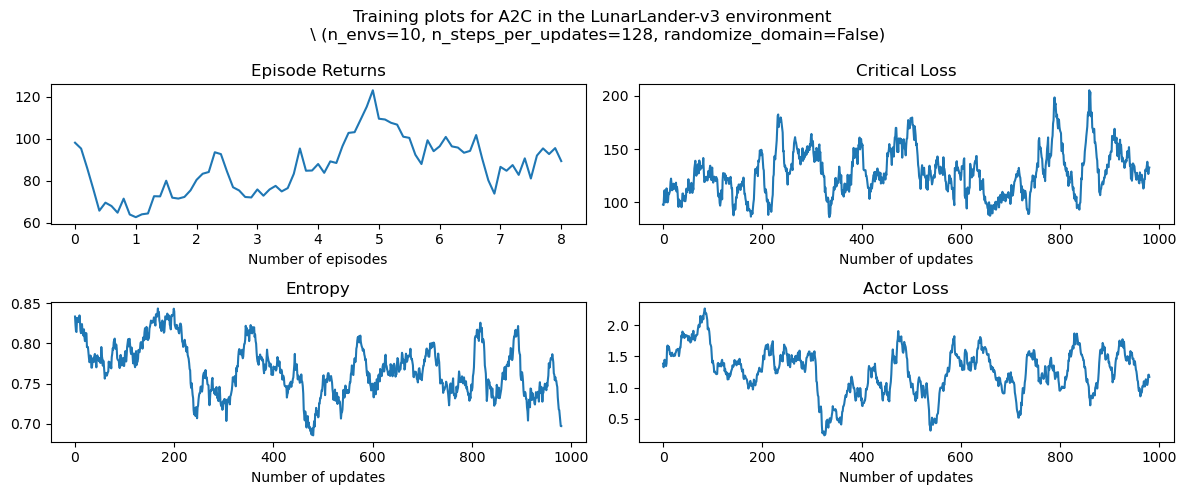

In [12]:
rolling_lenght = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(f"Training plots for {agent.__class__.__name__} in the LunarLander-v3 environment \n \ (n_envs={n_envs}, n_steps_per_updates={n_steps_per_update}, randomize_domain={randomize_domain})")

axs[0][0].set_title("Episode Returns")
episode_returns_moving_average = (np.convolve(np.array(envs_wrapper.return_queue).flatten(), np.ones(rolling_lenght), mode="valid") / rolling_lenght)
axs[0][0].plot(np.arange(len(episode_returns_moving_average)) / n_envs, episode_returns_moving_average,)
axs[0][0].set_xlabel("Number of episodes")

axs[1][0].set_title("Entropy")
entropy_moving_arange = (np.convolve(np.array(entropies), np.ones(rolling_lenght), mode="valid") / rolling_lenght)
axs[1][0].plot(entropy_moving_arange)
axs[1][0].set_xlabel("Number of updates")

axs[0][1].set_title("Critical Loss")
critical_losses_moving_average = (np.convolve(np.array(critic_losses).flatten(), np.ones(rolling_lenght), mode="valid") / rolling_lenght)
axs[0][1].plot(critical_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")

axs[1][1].set_title("Actor Loss")
actor_losses_moving_arange = (np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_lenght), mode="valid") / rolling_lenght)
axs[1][1].plot(actor_losses_moving_arange)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

In [14]:
save_weight = False
load_weight = False

actor_weights_path = "weights/actor_weights.h5"
critic_weights_path = "weights/critic_weights.h5"

if not os.path.exists("weights"):
    os.mkdir("weights")

if save_weight:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)

if load_weight:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr)
    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval()        

In [15]:
n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")
    
    if randomize_domain:
        env = gym.make("LunarLander-v3", render_mode="human", gravity=np.clip(np.random.normal(loc=-10.0, scale=2.0), a_min=-11.99, a_max=0.01),
                        enable_wind=np.random.choice([True, False]), wind_power=np.clip(np.random.normal(loc=15.0, scale=2.0), a_min=0.01, a_max=19.99),
                        turbulence_power=np.clip(np.random.normal(loc=1.5, scale=1.0), a_min=0.01, a_max=1.99), max_episode_steps=500)
    
    else:
        env = gym.make("LunarLander-v3", render_mode="human", max_episode_steps=500)

    state, info = env.reset()
    done = False

    while not done:
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None, :])    

        state, reward, terminated, truncated, info = env.step(action.item())

        done = terminated or truncated

env.close()        

starting episode 0...
starting episode 1...
starting episode 2...
